In [1]:
%load_ext sql
%config SqlMagic.feedback=False 
%config SqlMagic.autopandas=True
%sql sqlite:///whatsapp_chats.db

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from collections import Counter
import plotly.express as px
import emoji

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
def textDF(filename):
    filename = 'whatsapp_chats.txt'
    split_format = '(\d{2}/\d{2}/\d{2}, \d{2}:\d{2}) - (.*?): (.*)'
    datetime_format = '%d/%m/%Y, %H:%M - '

    with open(filename,'r',encoding='utf-8') as rawdata:
        raw_messages = rawdata.read().split('\n')
        messages = [re.findall(split_format,message)[0] for message in raw_messages if re.findall(split_format,message)]
    df = pd.DataFrame(messages,columns=['datetime','name','message'])
    df['datetime'] = pd.to_datetime(df['datetime'],format="%d/%m/%y, %H:%M")
    return df

In [4]:
whatsapp_tb = textDF('whatsapp_chats.txt')
whatsapp_tb.reset_index()

,index,datetime,name,message
0,0,2021-04-18 08:13:00,Vijay,Welcome Rajiv
1,1,2021-04-18 08:19:00,Vijay,🚩Unfortunately the new facility manager is not...
2,2,2021-04-18 12:53:00,Aslam,Can someone give me a contact for AC technicia...
3,3,2021-04-18 22:39:00,Preeti,This message was deleted
4,4,2021-04-19 09:33:00,Anand VC,<Media omitted>
...,...,...,...,...
1545,1545,2021-09-28 20:55:00,Jaya KM,Someone from Ablock 02 series dropping water f...
1546,1546,2021-09-28 22:19:00,Bhara Tippa,Same happened yesterday to my mother as well o...
1547,1547,2021-09-29 14:01:00,Jayla,Will be removing Honeybee in C block please as...
1548,1548,2021-09-29 14:01:00,Jayla,sir 01 series


In [28]:
whatsapp_tb['hour'] = whatsapp_tb['datetime'].dt.hour
whatsapp_tb['day'] = whatsapp_tb['datetime'].dt.day_name()
whatsapp_tb['dow'] = whatsapp_tb['datetime'].dt.dayofweek
whatsapp_tb['month'] = whatsapp_tb['datetime'].dt.month
whatsapp_tb['month_name'] = whatsapp_tb['datetime'].dt.month_name()
whatsapp_tb['year'] = whatsapp_tb['datetime'].dt.year
whatsapp_tb['date'] = whatsapp_tb['datetime'].dt.date
whatsapp_tb['letter_count'] = whatsapp_tb['message'].apply(lambda s : len(s))
whatsapp_tb['word_count'] = whatsapp_tb['message'].apply(lambda s : len(s.split(' ')))
whatsapp_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      1550 non-null   datetime64[ns]
 1   name          1550 non-null   object        
 2   message       1550 non-null   object        
 3   hour          1550 non-null   int64         
 4   day           1550 non-null   object        
 5   dow           1550 non-null   int64         
 6   month         1550 non-null   int64         
 7   month_name    1550 non-null   object        
 8   year          1550 non-null   int64         
 9   date          1550 non-null   object        
 10  letter_count  1550 non-null   int64         
 11  word_count    1550 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 145.4+ KB


In [6]:
%sql DROP table IF EXISTS whatsapp_tb;
%sql --persist whatsapp_tb
%sql select count(*) from whatsapp_tb

 * sqlite:///whatsapp_chats.db
 * sqlite:///whatsapp_chats.db
 * sqlite:///whatsapp_chats.db


,count(*)
0,1550


## Questions
##### 1. What is the data timeline & total user count?
##### 2. Which are the most active months of conversation?
##### 3. Which are the top 10 most active days of conversation?
##### 4. Which are the top 10 most silent days of conversation?
##### 5. Who are the top 10 most active users?
##### 6. Who are the top 10 most silent users?
##### 7. Who are the top 10 active media senders?
##### 8. Which are the most & least active days of the week?
##### 9. Which are the most & least active hours of the day?
##### 10. How are the word & letter counts per message distributed?
##### 11. Who are the top 10 high word count senders?
##### 12. Which are the top words used in messages?
##### 13. Which are the most sent emojis?

## 1. What is the data timeline & total user count

In [7]:
%sql select min(date) "START_DATE", max(date) "END_DATE", count(distinct name) "TOTAL_USERS" from whatsapp_tb

 * sqlite:///whatsapp_chats.db


,START_DATE,END_DATE,TOTAL_USERS
0,2021-04-18,2021-09-29,147


## 2. Which are the most active months of conversation?

 * sqlite:///whatsapp_chats.db


Text(0, 0.5, 'Total Messages')

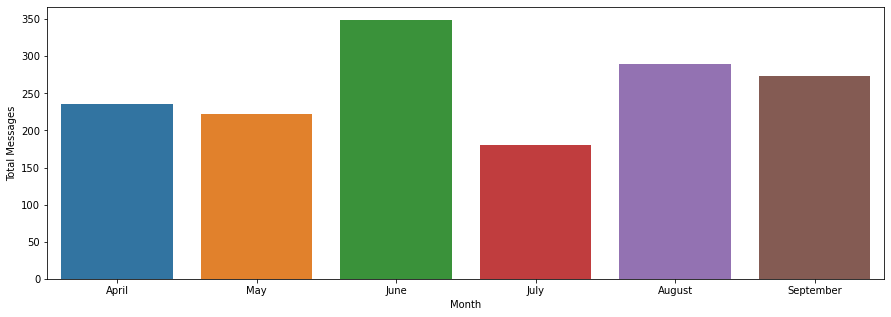

In [8]:
message_monthly_freq = %sql select month,month_name,count(*) msg_count from whatsapp_tb group by month,month_name order by month
plt.figure(figsize=(15,5))
plt.tight_layout()
sns.barplot(x=message_monthly_freq.month_name,y=message_monthly_freq.msg_count)
plt.xlabel('Month')
plt.ylabel('Total Messages')

## 3. Which are the top 10 most active days of conversation?

 * sqlite:///whatsapp_chats.db


Text(112.75, 0.5, 'Total Messages')

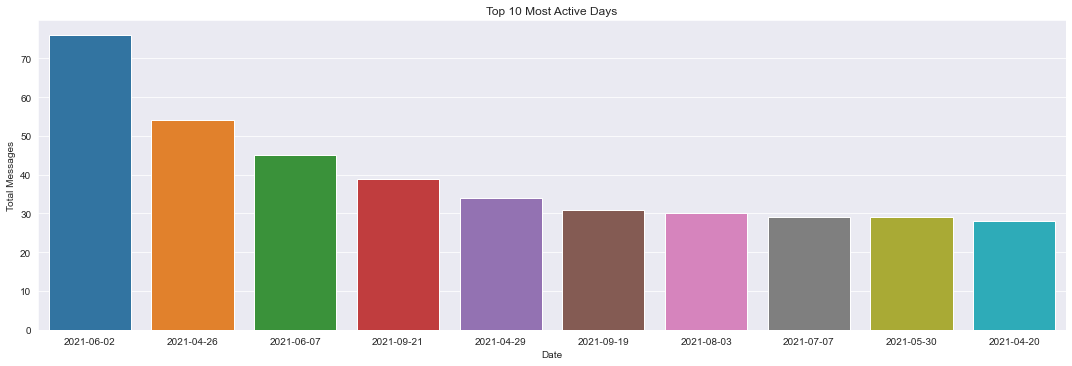

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
top_10_days_high = %sql select date,count(*) msg_count from whatsapp_tb where message <> 'This message was deleted' group by date order by 2 desc limit 10;
sns.barplot(x=top_10_days_high.date,y=top_10_days_high.msg_count)
plt.tight_layout()
plt.title("Top 10 Most Active Days")
plt.xlabel('Date')
plt.ylabel('Total Messages')

## 4. Which are the top 10 most silent days of conversation?

 * sqlite:///whatsapp_chats.db


Text(110.0, 0.5, 'Total Messages')

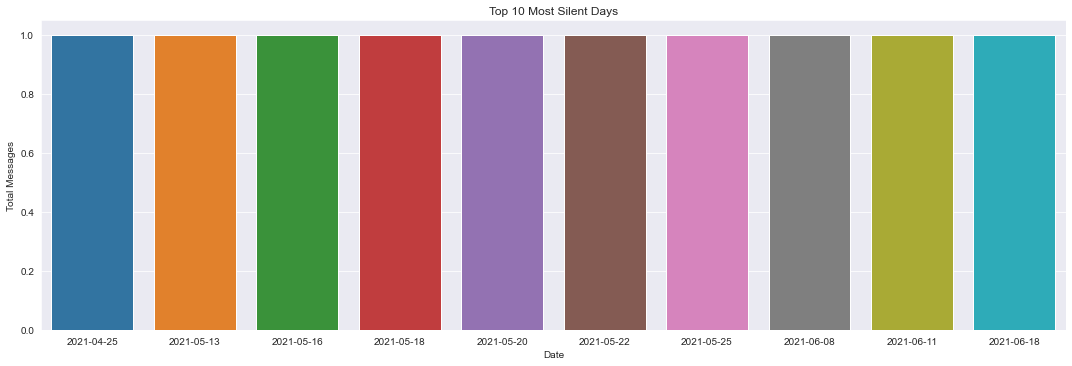

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
top_10_days_low = %sql select date,count(*) msg_count from whatsapp_tb where message <> 'This message was deleted' group by date order by 2 limit 10;
sns.barplot(x=top_10_days_low.date,y=top_10_days_low.msg_count)
plt.tight_layout()
plt.title("Top 10 Most Silent Days")
plt.xlabel('Date')
plt.ylabel('Total Messages')

## 5. Who are the top 10 most active users?

 * sqlite:///whatsapp_chats.db


Text(107.125, 0.5, 'Total Messages')

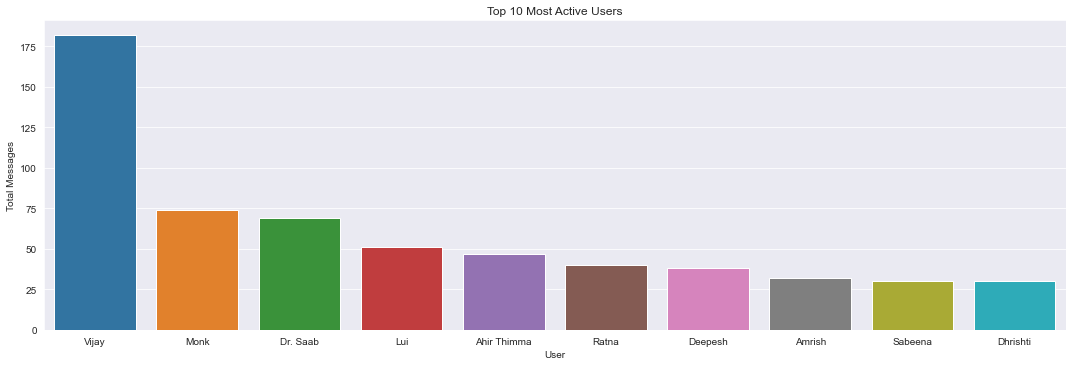

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
top_10_days_high = %sql select name,count(*) msg_count from whatsapp_tb where message <> 'This message was deleted' group by name order by 2 desc limit 10;
sns.barplot(x=top_10_days_high.name,y=top_10_days_high.msg_count)
plt.tight_layout()
plt.title("Top 10 Most Active Users")
plt.xlabel('User')
plt.ylabel('Total Messages')

## 6. Who are the top 10 most silent users?

 * sqlite:///whatsapp_chats.db


Text(110.0, 0.5, 'Total Messages')

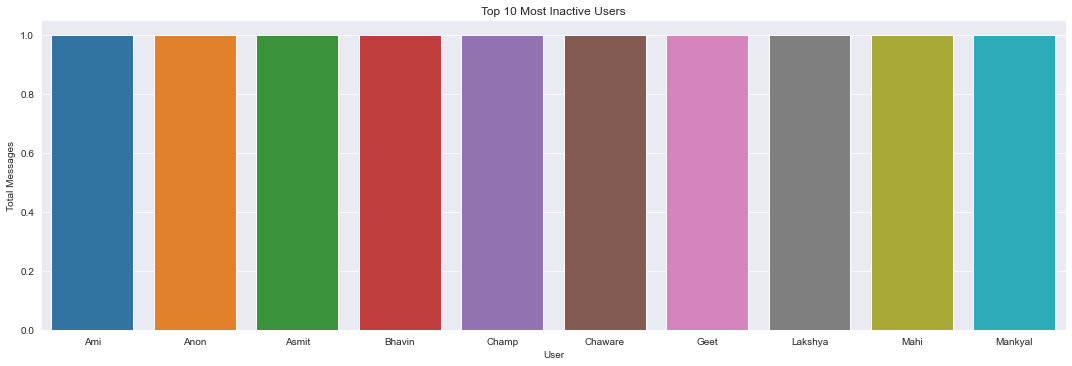

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
top_10_days_low = %sql select name,count(*) msg_count from whatsapp_tb where message <> 'This message was deleted' group by name order by 2 limit 10;
sns.barplot(x=top_10_days_low.name,y=top_10_days_low.msg_count)
plt.tight_layout()
plt.title("Top 10 Most Inactive Users")
plt.xlabel('User')
plt.ylabel('Total Messages')

## 7. Who are the top 10 active media senders?

 * sqlite:///whatsapp_chats.db


Text(112.75, 0.5, 'Total Messages')

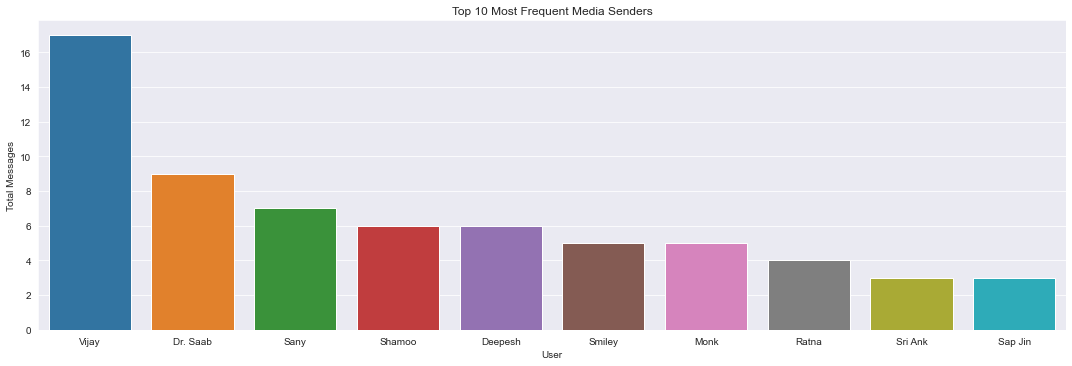

In [13]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
top_10_media_senders = %sql select name,count(*) msg_count from whatsapp_tb where message = '<Media omitted>' group by name order by 2 desc limit 10;
sns.barplot(x=top_10_media_senders.name,y=top_10_media_senders.msg_count)
plt.tight_layout()
plt.title("Top 10 Most Frequent Media Senders")
plt.xlabel('User')
plt.ylabel('Total Messages')

## 8. Which are the most & least active days of the week?

 * sqlite:///whatsapp_chats.db


Text(107.125, 0.5, 'Total Messages')

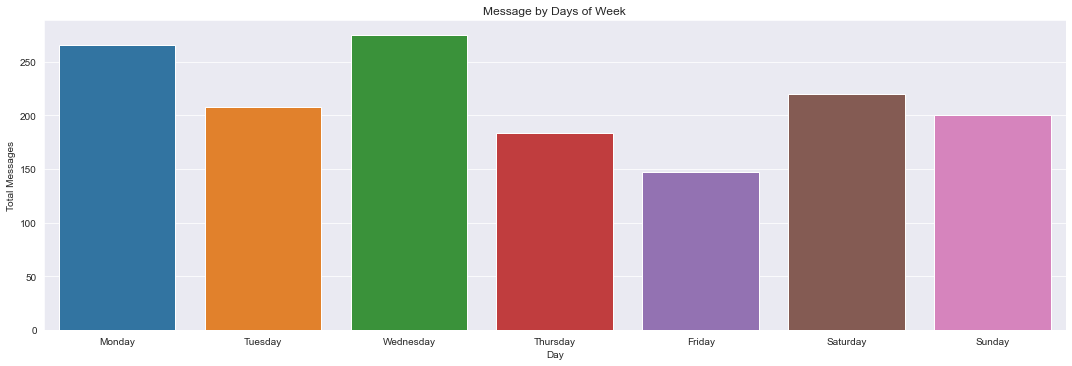

In [14]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
active_days = %sql select day,dow,count(*) msg_count from whatsapp_tb where message <> 'This message was deleted' group by day,dow order by dow;
sns.barplot(x=active_days.day,y=active_days.msg_count)
plt.tight_layout()
plt.title("Message by Days of Week")
plt.xlabel('Day')
plt.ylabel('Total Messages')

## 9. Which are the most & least active hours of the day?

 * sqlite:///whatsapp_chats.db


Text(107.125, 0.5, 'Total Messages')

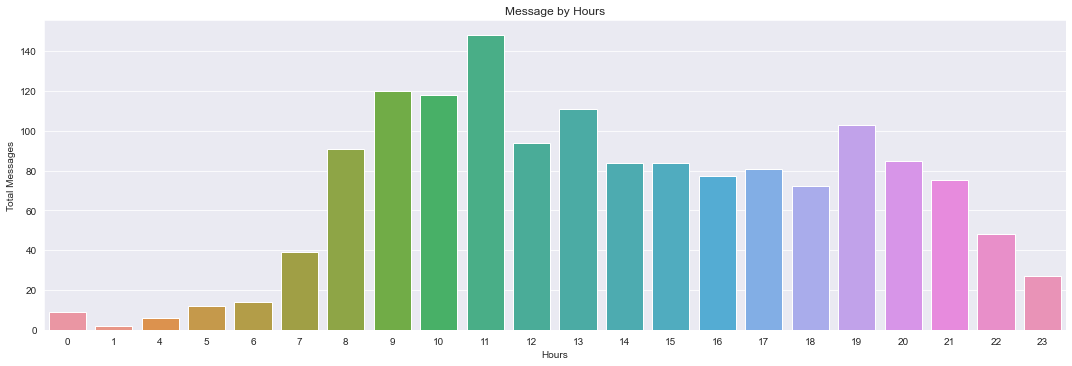

In [15]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
active_hours = %sql select hour,count(*) msg_count from whatsapp_tb where message <> 'This message was deleted' group by hour order by hour;
sns.barplot(x=active_hours.hour,y=active_hours.msg_count)
plt.tight_layout()
plt.title("Message by Hours")
plt.xlabel('Hours')
plt.ylabel('Total Messages')

## 10. How are the word & letter counts per message distributed?

 * sqlite:///whatsapp_chats.db
 * sqlite:///whatsapp_chats.db


Text(0.5, 1.0, 'Letters Distribution')

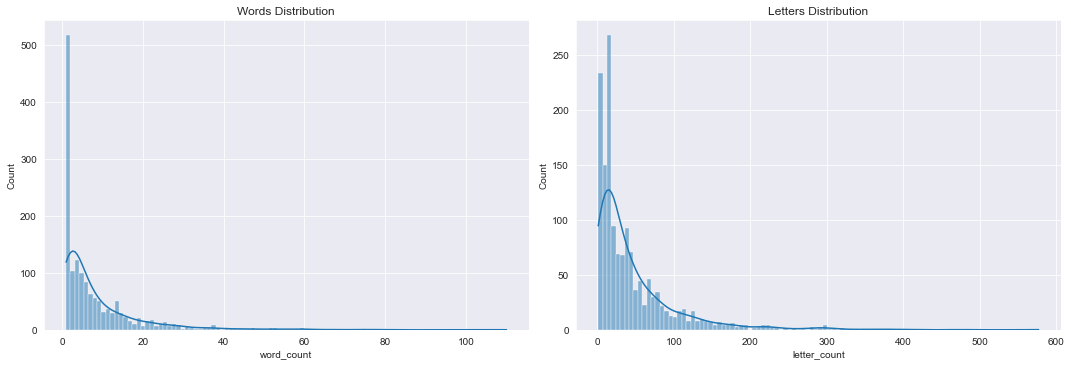

In [16]:
sns.set_style("darkgrid")
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
word_count_per_message = %sql select message,word_count from whatsapp_tb where message <> 'This message was deleted';
letter_count_per_message = %sql select message,letter_count from whatsapp_tb where message <> 'This message was deleted';
sns.histplot(x=word_count_per_message.word_count,kde=True,bins=100,ax=ax1)
sns.histplot(x=letter_count_per_message.letter_count,kde=True,bins=100,ax=ax2)
plt.tight_layout()
ax1.set_title("Words Distribution")
ax2.set_title("Letters Distribution")
#plt.xlabel('Words')

## 11. Who are the top 10 high word count senders?

 * sqlite:///whatsapp_chats.db


Text(112.75, 0.5, 'Average Word Count')

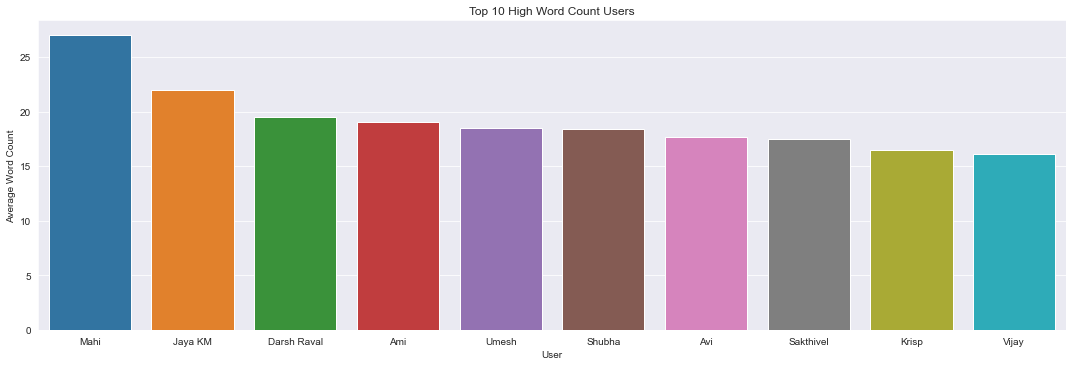

In [17]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,5))
top_10_high_word_count_users = %sql select name,avg(word_count) avg_word_count from whatsapp_tb where message <> 'This message was deleted' group by name order by 2 desc limit 10;
sns.barplot(x=top_10_high_word_count_users.name,y=top_10_high_word_count_users.avg_word_count)
plt.tight_layout()
plt.title("Top 10 High Word Count Users")
plt.xlabel('User')
plt.ylabel('Average Word Count')

## 12. Which are the top words used in messages?

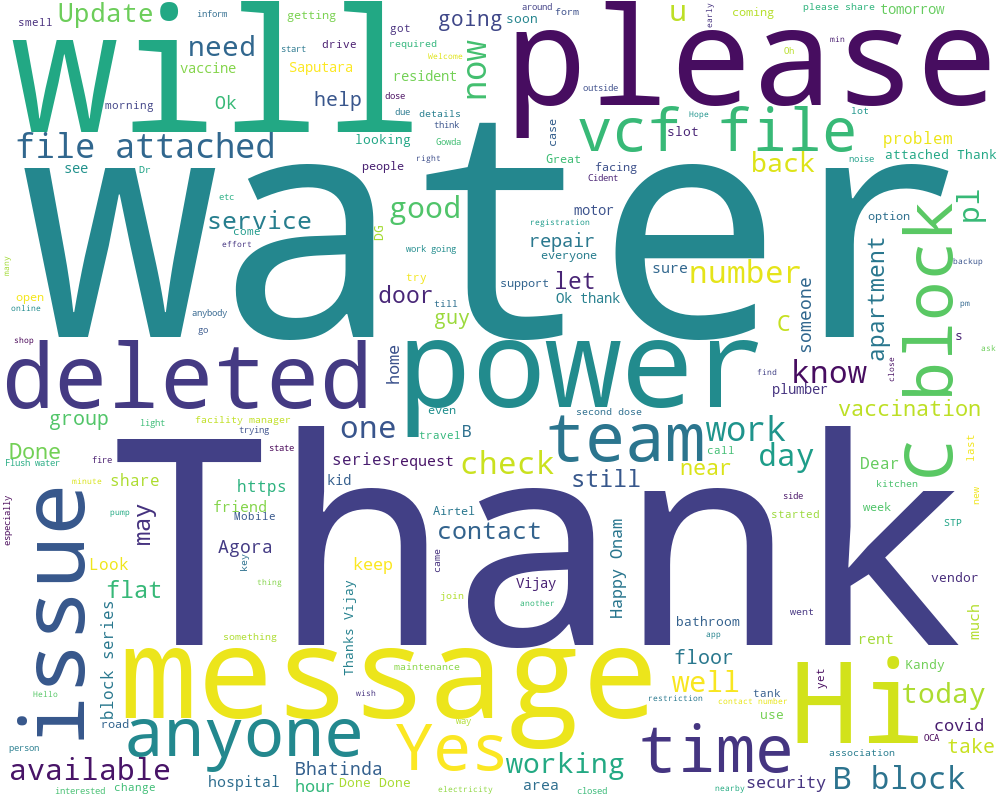

In [25]:
text = " ".join(message for message in whatsapp_tb[whatsapp_tb.message != '<Media omitted>'].message)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 1000, height = 800,stopwords=stopwords, background_color="white",min_font_size = 8).generate(text)
wordcloud.to_image()

## 13. Which are the most sent emojis?

In [19]:
emoji_lst = []
for word in whatsapp_tb.message:
    for letter in word:
        if (letter in emoji.UNICODE_EMOJI_ENGLISH):
            emoji_lst.append(letter)

In [20]:
counter = Counter(emoji_lst)
emoji_df = pd.DataFrame(counter.most_common(20),columns=['emoji','count'])

fig = px.pie(emoji_df, values='count', names='emoji',title='Emoji percentage used in chat group',)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()